In [1]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
from glob import glob
import matplotlib.pyplot as plt
import scipy
from math import lgamma
import seaborn as sns
%matplotlib inline

path = '/Users/chris/Desktop/mastrangelo/'


In [2]:
import matplotlib.pylab as pylab
pylab_params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(pylab_params)

total_stars = 67380

k = pd.Series([833, 134, 38, 15, 5, 0])

In [3]:
from ast import literal_eval

#https://stackoverflow.com/questions/52232742/how-to-use-ast-literal-eval-in-a-pandas-dataframe-and-handle-exceptions
def literal_eval_w_exceptions(x):
    try:
        return literal_eval(str(x))   
    except Exception as e:
        #print(e)
        pass

Read in and process data (pad and create zero bins)

In [4]:
truth = pd.read_csv(path+'collect_ground_truth.csv', converters=dict(transit_multiplicities=literal_eval))
recovery = pd.read_csv(path+'collect_recovery.csv', converters=dict(transit_multiplicities=literal_eval))


In [ ]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = truth.loc[(truth.ms == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logLs))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

#### Quality control

With so many records, some of them get corrupted. There are several ways we can deal with this, but since each model has 30 random samples, a corrupted record will simply be dropped. Therefore, later on, rather than summing to marginalize the log likelihoods, we take the mean. 

In [46]:
# retrieve indices of rows that somehow got padded with many extra bins
long_indices = recovery.loc[recovery['transit_multiplicities'].str.len() > 6]['transit_multiplicities'].index

# drop these rows
recovery = recovery.drop(long_indices)

In [5]:
zero_bins = []
transit_multiplicity_zero_bin = []
for j, i in enumerate(truth.transit_multiplicities[:]):
    zero_bins.append(total_stars-np.sum(i))
    temp = truth.reset_index().transit_multiplicities[:][j]
    temp.insert(0,total_stars - np.sum(i))
    transit_multiplicity_zero_bin.append(temp)
truth['transit_multiplicity_zero_bin'] = transit_multiplicity_zero_bin

zero_bins = []
transit_multiplicity_zero_bin = []
for j, i in enumerate(recovery.transit_multiplicities[:]):
    zero_bins.append(total_stars-np.sum(i))
    temp = recovery.reset_index().transit_multiplicities[:][j]
    temp.insert(0,total_stars - np.sum(i))
    transit_multiplicity_zero_bin.append(temp)
recovery['transit_multiplicity_zero_bin'] = transit_multiplicity_zero_bin

In [6]:
def pad(lam):
    lam += [0.] * (7 - len(lam)) # pad with zeros to match length of k
    return lam

truth['transit_multiplicities'] = truth.transit_multiplicities.apply(pad)
recovery['transit_multiplicities'] = recovery.transit_multiplicities.apply(pad)


Prepare machinery for injection-recovery experiments

In [6]:
def prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c):
    """
    Each model run will use an evenly spaced (m,b, cutoff) tuple on a discrete 11x11x11 3D grid
    We're doing log(time), so slope is sampled linearly (everything gets logged together later)
    If a cutoff results in a zero probability, don't bother 

    gi_m: grid index on m axis
    gi_b: grid index on b axis
    gi_c: grid index for cutoff time axis
    """
    #cube[0] = -1e-9*np.logspace(8,10,11)[gi_m] # convert from year to Gyr
    cube[0] = np.linspace(-1,0,6)[gi_m] 
    cube[1] = np.linspace(0,1,11)[gi_b]
    #cube[2] = np.logspace(1e8,1e10,11)
    cube[2] = np.round(np.logspace(8,10,11)[gi_c], 0) # in Ballard et al in prep, they use log(yrs) instead of drawing yrs from logspace
    return cube

In [7]:
def better_loglike(lam, k):
    """
    Calculate Poisson log likelihood
    Changed 0 handling from simulate.py to reflect https://www.aanda.org/articles/aa/pdf/2009/16/aa8472-07.pdf

    Params: 
    - lam: model predictions for transit multiplicity (list of ints)
    - k: Kepler transit multiplicity (list of ints); can accept alternate ground truths as well

    Returns: Poisson log likelihood (float)
    """

    # in the rare occasion that a simulated system has 7+ planets, throw them into the 6+ bin
    if len(k) < len(lam): 
        extras = lam[len(k):]
        sum_extras = np.sum(extras)
        lam[5] += sum_extras
    lam = lam[:6]
    
    logL = []
    for i in range(len(lam)):
        if lam[i]==0:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = 0
            logL.append(term1+term2+term3)

        else:
            term3 = -lgamma(k[i]+1)
            term2 = -lam[i]
            term1 = k[i]*np.log(lam[i])
            logL.append(term1+term2+term3)

    return np.sum(logL)

What would it look like to take the logL of something that's sqrt(N) deviated from the ground truth, where N is the number of systems in each bin? 

Answer: this is $\Delta$ logL of 3 different from the perfect case of comparing the ground truth to itself.

In [8]:
better_loglike(np.array([9900, 804, 122, 32, 11, 3, 0]), np.array([1e4, 833, 134, 38, 15, 5, 0]))

-23.261564101898227

In [79]:
def build_models(x, m, b, c, f): # adapted from Ballard et al in prep, log version
    """ 
    Calculate P(intact) as a function of time, in order to visualize sculpting models.

    Input:
    - x: grid of ages [log yrs]
    - m: sculpting law slope [dex]
    - b: sculpting law initial intact probability, out of planet-hosting stars
    - c: sculpting law turnoff time [log yrs]
    - f: fraction of planet-hosting stars

    Output:
    - y: grid of P(intacts)

    """

    # x-axis before cutoff
    x1 = x[x<c]
    x2 = x[x>=c]
    
    # first piece, before cutoff
    y1 = (b + m * (np.log10(x1) - 8)) * f
    
    # second piece, after cutoff
    y2 = np.ones(len(x2)) * (b + m * (np.log10(c) - 8)) * f
    
    y = np.concatenate((y1, y2))
    
    # flatten out at zero
    y = np.where(y < 0, 0, y)
    
    return y

#### Model 2: m = -1, b = 0.5, c = 4e9, f = 0.3 (heavy sculpting model)

In [162]:
tm_fiducial = truth.loc[(truth.ms == -1.) & (truth.bs == 0.5) & (np.round(truth.cs, -8) == 4e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

692    [616.5, 34.8, 0.0, 0.0, 0.0, 0.0]
Name: transit_multiplicities, dtype: object

In [163]:
test_recovery = recovery.loc[(recovery.ms == -1.) & (recovery.bs == 0.5) & (np.round(recovery.cs, -8) == 4e9) & (np.round(recovery.fs,1) == 0.3)]


Let's quickly check their transit yields to see whether they make sense.

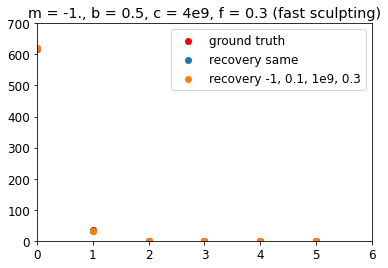

In [164]:
plt.scatter(np.arange(len(tm_fiducial[692])), tm_fiducial[692], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[20760].transit_multiplicities)), recovery.iloc[20760].transit_multiplicities, label='recovery same')
plt.scatter(np.arange(len(recovery.iloc[5470].transit_multiplicities)), recovery.iloc[5470].transit_multiplicities, label='recovery -1, 0.1, 1e9, 0.3')

plt.xlim([0,6])
plt.ylim([0,700])
plt.title('m = -1., b = 0.5, c = 4e9, f = 0.3 (fast sculpting)')
plt.legend()
plt.show()

This makes sense: the yields between higher b but short-lived sculpting and lower b but longer-lived sculpting are similar.

In [202]:
def argmedian(x):
    return np.argpartition(x, len(x) // 2)[len(x) // 2] # // is floor division

In [203]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # take the median logL for each model
                    median_logL = np.median(logLs)
                    median_arg = argmedian(logLs)
                    all_logLs.append(median_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[median_arg])

                except:
                    all_logLs.append(0.)
                

In [205]:
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'injection_transit_multiplicities': all_transit_multiplicities, 
                            'logL': all_logLs})
model_logLs

,m,b,c,f,injection_transit_multiplicities,logL
0,-1.0,0.0,1.000000e+08,0.1,"[202.70000000000002, 12.200000000000001, 0.0, ...",-292.656186
1,-1.0,0.0,1.000000e+08,0.2,"[408.6, 23.6, 0.0, 0.0, 0.0, 0.0]",-55.465881
2,-1.0,0.0,1.000000e+08,0.3,"[611.1, 31.2, 0.0, 0.0, 0.0, 0.0]",-7.061195
3,-1.0,0.0,1.000000e+08,0.4,"[810.8000000000001, 48.800000000000004, 0.0, 0...",-35.019123
4,-1.0,0.0,1.000000e+08,0.5,"[1013.5, 61.0, 0.0, 0.0, 0.0, 0.0]",-105.185728
...,...,...,...,...,...,...
7255,0.0,1.0,1.000000e+10,0.6,"[1386.0, 706.8, 381.59999999999997, 157.799999...",-1424.313592
7256,0.0,1.0,1.000000e+10,0.7,"[1696.1, 812.0, 420.7, 168.0, 49.0, 4.19999999...",-1774.311494
7257,0.0,1.0,1.000000e+10,0.8,"[1938.4, 928.0, 480.8, 192.0, 56.0, 4.80000000...",-2138.092498
7258,0.0,1.0,1.000000e+10,0.9,"[2180.7000000000003, 1044.0, 540.9, 216.0, 63....",-2511.580396


### Note that while these logLs take f into account, they do not take the zero-bin into account. analyze.ipynb has machinery to handle that, and we can do this injection-recovery routine with those logLs instead, if we want. 

#### What is the $\Delta$ logL between the very best model and the ground truth?

Identify best and good models

In [206]:
x = np.logspace(8, 10, 1000)

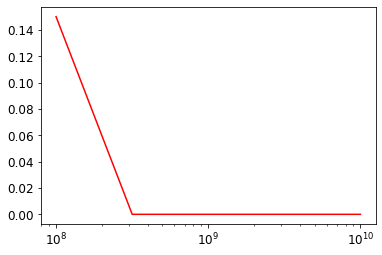

In [207]:
ground_truth = model_logLs.loc[(model_logLs.m == -1) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -8) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')
plt.xscale('log')


In [209]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == -1) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -9) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth)
delta_logL = best_logL - model_logLs.loc[(model_logLs.m == -1) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -9) == 4e9) & (np.round(model_logLs.f,1) == 0.3)].logL.to_list()[0]

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) <= delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:          m    b             c    f   injection_transit_multiplicities     logL
1312 -0.8  0.0  1.000000e+10  0.3  [621.9, 32.4, 0.0, 0.0, 0.0, 0.0] -6.95384
Ground truth:         m    b             c    f   injection_transit_multiplicities      logL
632 -1.0  0.5  3.981072e+09  0.3  [621.0, 34.5, 0.3, 0.6, 0.0, 0.0] -7.784932
Some models between best model and ground truth: 
      m    b            c    f  \
2  -1.0  0.0  100000000.0  0.3   
12 -1.0  0.0  158489319.0  0.3   
22 -1.0  0.0  251188643.0  0.3   
32 -1.0  0.0  398107171.0  0.3   
42 -1.0  0.0  630957344.0  0.3   

                   injection_transit_multiplicities      logL  
2                 [611.1, 31.2, 0.0, 0.0, 0.0, 0.0] -7.061195  
12  [625.5, 31.799999999999997, 0.0, 0.0, 0.0, 0.0] -7.033363  
22                [630.0, 36.0, 0.0, 0.0, 0.0, 0.0] -6.994674  
32  [616.5, 38.699999999999996, 0.0, 0.0, 0.0, 0.0] -7.040230  
42                [604.5, 37.5, 0.0, 0.0, 0.0, 0.0] -7.045327  


Hold on: why are there multiple best models? EDIT 1: It seems like some data swapping happened when the simulations were made. So, I have to identify the real one and then drop the other rows. EDIT 2: Maybe the sure-fire way is to re-draw a simulation with my unit test script and see how close it gets to the apparently-copied data? EDIT 3: This problem went away when I went from taking the best logL per 30 draws of a model, to taking the median logL per 30 draws of a model.

In [176]:
model_logLs.iloc[1380:1390] # this is the right one

,m,b,c,f,injection_transit_multiplicities,logL
1380,-0.8,0.1,1.584893e+09,0.1,"[214.20000000000002, 11.3, 0.0, 0.0, 0.0, 0.0]",-271.902638
1381,-0.8,0.1,1.584893e+09,0.2,"[428.40000000000003, 22.6, 0.0, 0.0, 0.0, 0.0]",-45.955880
1382,-0.8,0.1,1.584893e+09,0.3,"[616.5, 34.8, 0.0, 0.0, 0.0, 0.0]",-6.827245
1383,-0.8,0.1,1.584893e+09,0.4,"[778.4000000000001, 38.400000000000006, 0.0, 0...",-25.144699
1384,-0.8,0.1,1.584893e+09,0.5,"[973.0, 48.0, 0.0, 0.0, 0.0, 0.0]",-84.011304
1385,-0.8,0.1,1.584893e+09,0.6,"[1167.6, 57.599999999999994, 0.0, 0.0, 0.0, 0.0]",-169.465274
1386,-0.8,0.1,1.584893e+09,0.7,"[1362.1999999999998, 67.19999999999999, 0.0, 0...",-273.266936
1387,-0.8,0.1,1.584893e+09,0.8,"[1556.8000000000002, 76.80000000000001, 0.0, 0...",-390.497940
1388,-0.8,0.1,1.584893e+09,0.9,"[1751.4, 86.4, 0.0, 0.0, 0.0, 0.0]",-517.985849
1389,-0.8,0.1,1.584893e+09,1.0,"[1946.0, 96.0, 0.0, 0.0, 0.0, 0.0]",-653.564545


In [177]:
model_logLs.iloc[1490:1500]

,m,b,c,f,injection_transit_multiplicities,logL
1490,-0.8,0.2,1.584893e+09,0.1,"[214.8, 11.700000000000001, 0.1, 0.1, 0.0, 0.0]",-270.167605
1491,-0.8,0.2,1.584893e+09,0.2,"[429.6, 23.400000000000002, 0.2, 0.2, 0.0, 0.0]",-45.420846
1492,-0.8,0.2,1.584893e+09,0.3,"[616.5, 34.8, 0.0, 0.0, 0.0, 0.0]",-6.827245
1493,-0.8,0.2,1.584893e+09,0.4,"[780.0, 50.0, 0.4, 0.4, 0.0, 0.0]",-28.692784
1494,-0.8,0.2,1.584893e+09,0.5,"[975.0, 62.5, 0.5, 0.5, 0.0, 0.0]",-91.059389
1495,-0.8,0.2,1.584893e+09,0.6,"[1170.0, 75.0, 0.6, 0.6, 0.0, 0.0]",-180.013359
1496,-0.8,0.2,1.584893e+09,0.7,"[1365.0, 87.5, 0.7, 0.7, 0.0, 0.0]",-287.315021
1497,-0.8,0.2,1.584893e+09,0.8,"[1560.0, 100.0, 0.8, 0.8, 0.0, 0.0]",-408.046025
1498,-0.8,0.2,1.584893e+09,0.9,"[1755.0, 112.5, 0.9, 0.9, 0.0, 0.0]",-539.033934
1499,-0.8,0.2,1.584893e+09,1.0,"[1950.0, 125.0, 1.0, 1.0, 0.0, 0.0]",-678.112630


In [178]:
model_logLs.iloc[3750:3760]

,m,b,c,f,injection_transit_multiplicities,logL
3750,-0.4,0.1,158489319.0,0.1,"[214.9, 14.5, 1.3, 0.4, 0.4, 0.0]",-267.213979
3751,-0.4,0.1,158489319.0,0.2,"[429.8, 29.0, 2.6, 0.8, 0.8, 0.0]",-47.267220
3752,-0.4,0.1,158489319.0,0.3,"[616.5, 34.8, 0.0, 0.0, 0.0, 0.0]",-6.827245
3753,-0.4,0.1,158489319.0,0.4,"[784.0, 47.6, 0.4, 0.0, 0.0, 0.0]",-28.451144
3754,-0.4,0.1,158489319.0,0.5,"[980.0, 59.5, 0.5, 0.0, 0.0, 0.0]",-91.117750
3755,-0.4,0.1,158489319.0,0.6,"[1176.0, 71.39999999999999, 0.6, 0.0, 0.0, 0.0]",-180.371720
3756,-0.4,0.1,158489319.0,0.7,"[1372.0, 83.3, 0.7, 0.0, 0.0, 0.0]",-287.973382
3757,-0.4,0.1,158489319.0,0.8,"[1568.0, 95.2, 0.8, 0.0, 0.0, 0.0]",-409.004386
3758,-0.4,0.1,158489319.0,0.9,"[1764.0, 107.10000000000001, 0.9, 0.0, 0.0, 0.0]",-540.292295
3759,-0.4,0.1,158489319.0,1.0,"[1960.0, 119.0, 1.0, 0.0, 0.0, 0.0]",-679.670991


In [179]:
model_logLs.iloc[3840:3850]

,m,b,c,f,injection_transit_multiplicities,logL
3840,-0.4,0.1,1.000000e+10,0.1,"[215.3, 9.600000000000001, 0.1, 0.0, 0.0, 0.0]",-273.918552
3841,-0.4,0.1,1.000000e+10,0.2,"[423.40000000000003, 24.8, 0.2, 0.0, 0.0, 0.0]",-47.360875
3842,-0.4,0.1,1.000000e+10,0.3,"[616.5, 34.8, 0.0, 0.0, 0.0, 0.0]",-6.827245
3843,-0.4,0.1,1.000000e+10,0.4,"[784.0, 47.6, 0.4, 0.0, 0.0, 0.0]",-28.451144
3844,-0.4,0.1,1.000000e+10,0.5,"[980.0, 59.5, 0.5, 0.0, 0.0, 0.0]",-91.117750
3845,-0.4,0.1,1.000000e+10,0.6,"[1176.0, 71.39999999999999, 0.6, 0.0, 0.0, 0.0]",-180.371720
3846,-0.4,0.1,1.000000e+10,0.7,"[1372.0, 83.3, 0.7, 0.0, 0.0, 0.0]",-287.973382
3847,-0.4,0.1,1.000000e+10,0.8,"[1568.0, 95.2, 0.8, 0.0, 0.0, 0.0]",-409.004386
3848,-0.4,0.1,1.000000e+10,0.9,"[1764.0, 107.10000000000001, 0.9, 0.0, 0.0, 0.0]",-540.292295
3849,-0.4,0.1,1.000000e+10,1.0,"[1960.0, 119.0, 1.0, 0.0, 0.0, 0.0]",-679.670991


Let's drop the three likely bad data and find the best and good models again.

In [180]:
model_logLs = model_logLs.drop([1492, 3752, 3842])

In [181]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == -1) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -9) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth.logL)
delta_logL = best_logL - model_logLs.loc[(model_logLs.m == -1) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -9) == 4e9) & (np.round(model_logLs.f,1) == 0.3)].logL.to_list()[0]

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) <= delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:          m    b             c    f   injection_transit_multiplicities      logL
1382 -0.8  0.1  1.584893e+09  0.3  [616.5, 34.8, 0.0, 0.0, 0.0, 0.0] -6.827245
Ground truth:  632   -6.837797
Name: logL, dtype: float64
Some models between best model and ground truth: 
      m    b             c    f  \
12 -1.0  0.0  1.584893e+08  0.3   
52 -1.0  0.0  1.000000e+09  0.3   
72 -1.0  0.0  2.511886e+09  0.3   
82 -1.0  0.0  3.981072e+09  0.3   
92 -1.0  0.0  6.309573e+09  0.3   

                 injection_transit_multiplicities      logL  
12  [617.6999999999999, 34.5, 0.0, 0.0, 0.0, 0.0] -6.829712  
52              [613.5, 34.5, 0.0, 0.0, 0.0, 0.0] -6.835868  
72              [618.0, 35.1, 0.0, 0.0, 0.0, 0.0] -6.830352  
82  [617.6999999999999, 35.4, 0.0, 0.0, 0.0, 0.0] -6.833525  
92  [617.6999999999999, 34.8, 0.0, 0.0, 0.0, 0.0] -6.828411  


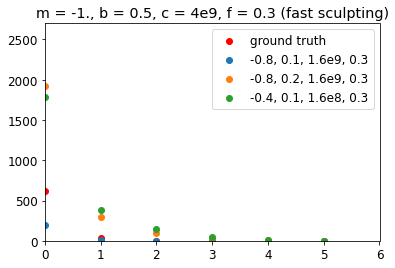

In [210]:
plt.scatter(np.arange(len(tm_fiducial[692])), tm_fiducial[692], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[6909].transit_multiplicities)), recovery.iloc[6909].transit_multiplicities, label='-0.8, 0.1, 1.6e9, 0.3')
plt.scatter(np.arange(len(recovery.iloc[7459].transit_multiplicities)), recovery.iloc[7459].transit_multiplicities, label='-0.8, 0.2, 1.6e9, 0.3')
plt.scatter(np.arange(len(recovery.iloc[18759].transit_multiplicities)), recovery.iloc[18759].transit_multiplicities, label='-0.4, 0.1, 1.6e8, 0.3')

plt.xlim([0,6])
plt.ylim([0,2700])
plt.title('m = -1., b = 0.5, c = 4e9, f = 0.3 (fast sculpting)')
plt.legend()
plt.show()

The green functional no-sculpting model has 6.5% multi:single ratio; compared to the blue sculpting model with 5.8% multi:single ratio, this is sensible.

Plot these models

-0.8 0.0 10000000000.0 0.3
-1.0 0.5 3981071706.0 0.3


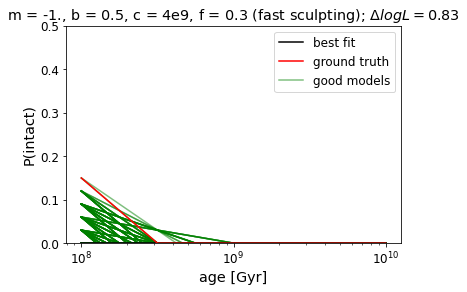

In [211]:
# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
print(m, b, c, f)
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
print(m, b, c, f)
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='good models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(f'm = -1., b = 0.5, c = 4e9, f = 0.3 (fast sculpting); $\Delta logL = {np.round(delta_logL,2)}$')
plt.legend()
plt.show()

#### Normalizing no-sculpting models, which are fewer than the others

In [30]:
model_logLs.loc[(model_logLs.m == 0.) & (model_logLs.f == 0.1)]

,m,b,c,f,logL
30250,0.0,0.0,1.000000e+08,0.1,-276.863070
30251,0.0,0.0,1.000000e+08,0.1,-276.863070
30252,0.0,0.0,1.000000e+08,0.1,-276.863070
30300,0.0,0.0,1.584893e+08,0.1,-271.592268
30301,0.0,0.0,1.584893e+08,0.1,-271.592268
...,...,...,...,...,...
36201,0.0,1.0,6.309573e+09,0.1,-335.635030
36202,0.0,1.0,6.309573e+09,0.1,-335.635030
36250,0.0,1.0,1.000000e+10,0.1,-332.059695
36251,0.0,1.0,1.000000e+10,0.1,-332.059695


Ope! Looks like I've lost a few differing cutoff timescale files for the case of no sculpting. Fortunately, this edge case means that the logL should be the same regardless of cutoff time. 

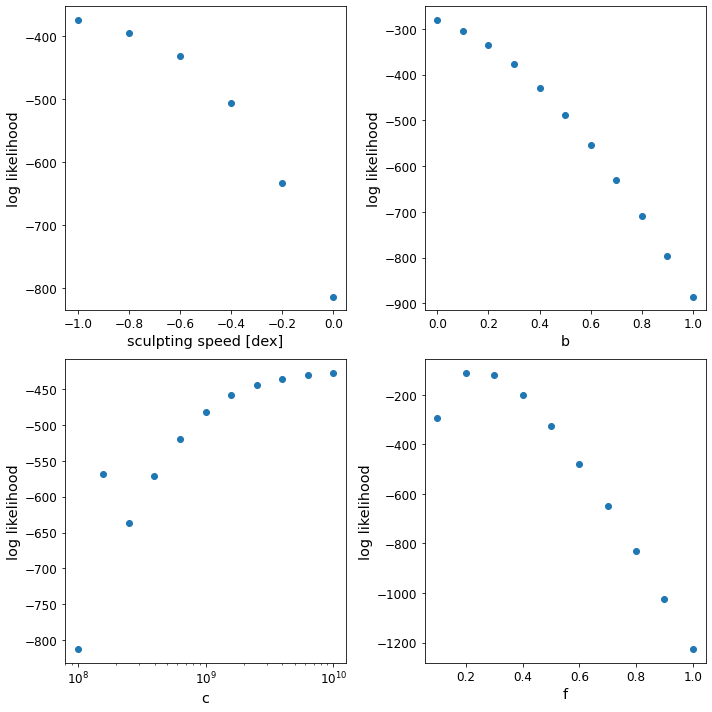

In [213]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))

ax1.scatter(model_logLs.m.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax3.scatter(model_logLs.c.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

In [192]:
print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].logL.mean())
print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].logL.mean())


-392.3885850797899
-595.5360074768579


It seems like no matter the ground truth, I always favor the second cutoff threshold. Why is that? This subset of models has the same number of records (eg. no dropped data) and similar mins and maxes to adjacent models (ie. the subsequent cutoff threshold of 2.5e8 yrs). So, what gives? 

     m    b            c    f   injection_transit_multiplicities        logL
0 -1.0  0.0  100000000.0  0.1  [210.8, 13.0, 0.0, 0.0, 0.0, 0.0] -275.189746
1 -1.0  0.0  100000000.0  0.2  [421.6, 26.0, 0.0, 0.0, 0.0, 0.0]  -47.542987
2 -1.0  0.0  100000000.0  0.3  [612.9, 35.4, 0.0, 0.0, 0.0, 0.0]   -6.842910
3 -1.0  0.0  100000000.0  0.4  [787.2, 51.6, 0.0, 0.0, 0.0, 0.0]  -29.931965
4 -1.0  0.0  100000000.0  0.5  [984.0, 64.5, 0.0, 0.0, 0.0, 0.0]  -94.298570


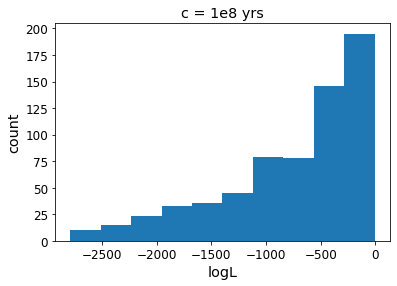

      m    b            c    f  \
10 -1.0  0.0  158489319.0  0.1   
11 -1.0  0.0  158489319.0  0.2   
12 -1.0  0.0  158489319.0  0.3   
13 -1.0  0.0  158489319.0  0.4   
14 -1.0  0.0  158489319.0  0.5   

                     injection_transit_multiplicities        logL  
10  [213.10000000000002, 12.200000000000001, 0.0, ... -272.209926  
11  [426.20000000000005, 24.400000000000002, 0.0, ...  -46.063167  
12      [617.6999999999999, 34.5, 0.0, 0.0, 0.0, 0.0]   -6.829712  
13  [764.4000000000001, 44.400000000000006, 0.0, 0...  -23.281420  
14                  [955.5, 55.5, 0.0, 0.0, 0.0, 0.0]  -80.148025  


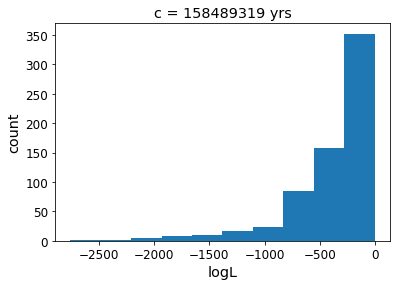

      m    b            c    f  \
20 -1.0  0.0  251188643.0  0.1   
21 -1.0  0.0  251188643.0  0.2   
22 -1.0  0.0  251188643.0  0.3   
23 -1.0  0.0  251188643.0  0.4   
24 -1.0  0.0  251188643.0  0.5   

                   injection_transit_multiplicities        logL  
20                [210.3, 14.5, 0.0, 0.0, 0.0, 0.0] -273.853634  
21                [420.6, 29.0, 0.0, 0.0, 0.0, 0.0]  -47.206875  
22                [612.3, 34.8, 0.0, 0.0, 0.0, 0.0]   -6.841617  
23  [767.2, 48.400000000000006, 0.0, 0.0, 0.0, 0.0]  -24.825444  
24                [959.0, 60.5, 0.0, 0.0, 0.0, 0.0]  -83.392049  


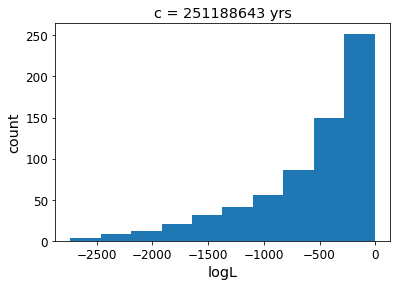

In [187]:
print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[0], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[0], 0))].logL)
plt.title('c = 1e8 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].logL)
plt.title('c = 158489319 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].logL)
plt.title('c = 251188643 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()


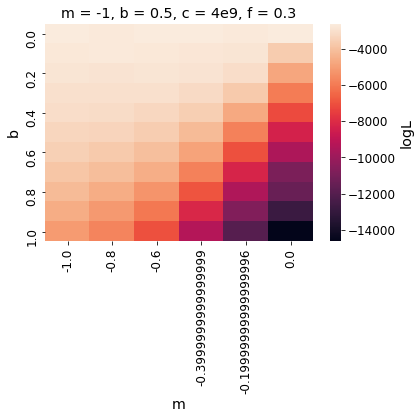

In [33]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -1, b = 0.5, c = 4e9, f = 0.3')
plt.show()

In [34]:
piv

m,-1.0,-0.8,-0.6,-0.4,-0.2,0.0
b,,,,,,
0.0,-2649.934111,-2704.753190,-2632.350792,-2657.005839,-2711.639772,-2657.940952
0.1,-2749.909286,-2680.635465,-2757.914842,-2773.631842,-2841.760153,-3660.976296
0.2,-2861.673762,-2885.096254,-2856.951410,-2909.054922,-3095.593939,-4751.362645
0.3,-2979.304046,-2989.071961,-3005.338446,-3159.418417,-3695.695812,-5933.246537
0.4,-3080.652676,-3136.029843,-3268.964012,-3524.232233,-4675.517010,-7158.009496
0.5,-3293.167656,-3382.951232,-3617.476782,-4163.447304,-5804.905745,-8353.794136
0.6,-3509.819421,-3711.553268,-4026.255073,-4877.444818,-7014.908184,-9509.512440
0.7,-3826.543095,-4084.676091,-4540.260640,-5806.813419,-8227.789013,-10846.967932
0.8,-4151.930809,-4584.181091,-5294.015567,-6926.490019,-9455.767917,-11413.150642


In [35]:
model_logLs.loc[model_logLs.f == 0.3].groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL')

c    f         logL
m    b                                  
-1.0 0.0  2.692617e+10  3.3  -146.408332
     0.1  2.692617e+10  3.3  -177.369264
     0.2  2.692617e+10  3.3  -217.259840
     0.3  2.692617e+10  3.3  -266.159528
     0.4  2.692617e+10  3.3  -316.002271
...                ...  ...          ...
 0.0 0.6  2.692617e+10  3.3 -3112.789403
     0.7  2.692617e+10  3.3 -3731.431045
     0.8  2.692617e+10  3.3 -4213.381086
     0.9  2.692617e+10  3.3 -4815.177203
     1.0  2.692617e+10  3.3 -5557.031939

[66 rows x 3 columns]

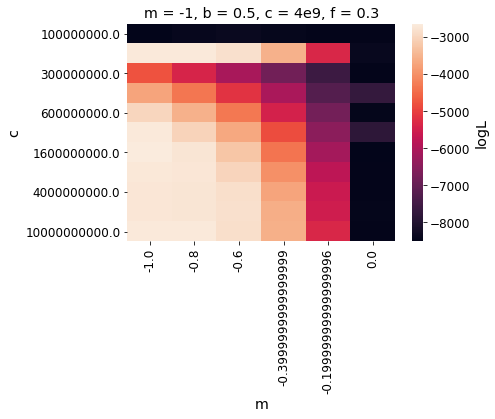

In [37]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.c.unique().round(-8), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -1, b = 0.5, c = 4e9, f = 0.3')
plt.show()

It looks like we recover a cutoff time of 2.5 Gyrs instead of 4 Gyrs, as well as {m=0, b=0.5} instead of {m=-1, b=0.5}, although the latter is a close one, and in general the 1D posteriors show that m=0 is generally bad.

The mystery around why the models seem to love the second cutoff threshold continues to deepen, as I show in the first three attached plots for the fake ground truth of fast sculpting (m = -1, b = 0.5, c = 4e9, f = 0.3). The middle plot of 1.6e8 years shows a shorter tail than the adjacent cutoff times. 

EDIT: Actually, I don’t think this is as big a mystery as it seemed; as shown by the two other ground truths below. The only question is why all three ground truths favor a cutoff time that is way younger than the median age of the stellar sample…which suggests that no matter what’s real, sculpting is always going to appear to be very short-lived.

I am also finding that when I examine the raw simulation outputs from HPG, sometimes some models get the exact same transit multiplicity. Either this is some coincidence, or some as yet undiscovered bug, or some copying of data happened in the distributed HPG job. This happens only a few times, as far as I can tell. My ad hoc solution is to manually identify the original correct record and drop the incorrect ones, but I can only identify them as they come to my attention (which is when a spuriously copied multiplicity happens to be better than the other 29 draws and elevates a model beyond where it should be). I have switched to taking the median out of each 30ish samples instead of the max, and that seems to be a little more robust, but the weird favoring of the second cutoff time still persists.

Finally, the ground truth plot says a cutoff of 4e9, but since that model’s slope takes us below zero well before then, that is as good as any model with a cutoff time after that zero point. So, perhaps I should have chosen a more sensible ground truth.

#### Model 3: m = -0.6, b = 1.0, c = 1e9, f = 0.3 (medium sculpting)


Before we proceed, let's take a detour to check that the transit multiplicity yields for different models are different in the ways that we expect. For example, a model with more sculpting and/or fewer initially intact systems should have fewer multis.

In [214]:
tm_fiducial = truth.loc[(truth.ms == -0.6) & (truth.bs == 1.) & (np.round(truth.cs, -8) == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

3902    [676.5, 162.9, 71.1, 29.7, 7.199999999999999, ...
Name: transit_multiplicities, dtype: object

In [215]:
test_recovery = recovery.loc[(recovery.ms == -0.6) & (recovery.bs == 1.) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)].transit_multiplicities

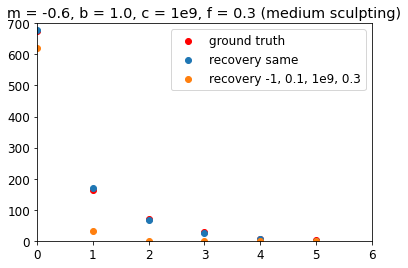

In [216]:
plt.scatter(np.arange(len(tm_fiducial[3902])), tm_fiducial[3902], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[117060].transit_multiplicities)), recovery.iloc[117060].transit_multiplicities, label='recovery same')
plt.scatter(np.arange(len(recovery.iloc[5470].transit_multiplicities)), recovery.iloc[5470].transit_multiplicities, label='recovery -1, 0.1, 1e9, 0.3')

plt.xlim([0,6])
plt.ylim([0,700])
plt.title('m = -0.6, b = 1.0, c = 1e9, f = 0.3 (medium sculpting)')
plt.legend()
plt.show()

Both in count and relative to singles, there are fewer multis represented by the orange dots than the blue/red dots. Anyway, let's continue to check out injection-recovery for medium sculpting models.

In [217]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # keep median logL for each model
                    median_logL = np.mean(logLs)
                    median_arg = argmedian(logLs)
                    all_logLs.append(median_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[median_arg])

                except:
                    all_logLs.append(0.)
                
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'tm': all_transit_multiplicities, 'logL': all_logLs})
        

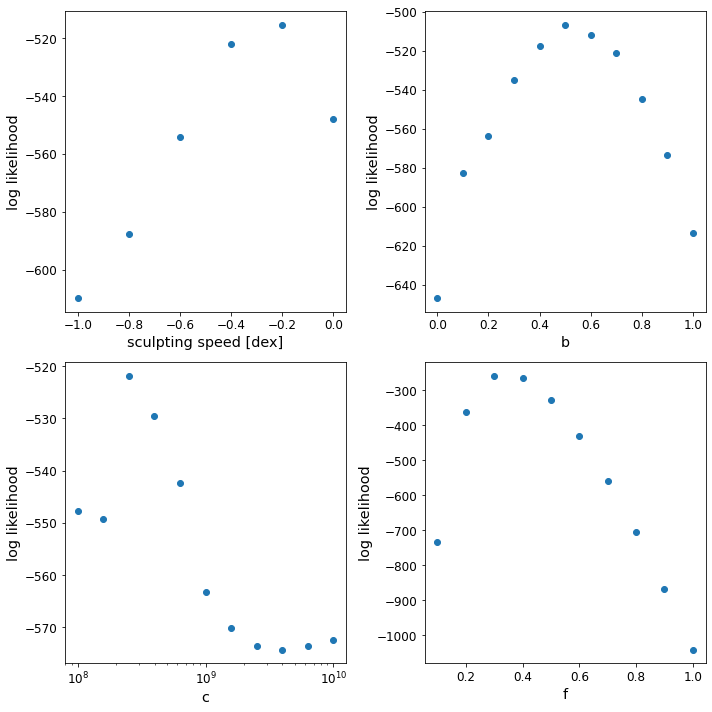

In [218]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

Second cutoff threshold mystery continues...

     m    b            c    f                                  tm        logL
0 -1.0  0.0  100000000.0  0.1   [202.3, 12.0, 0.0, 0.0, 0.0, 0.0] -942.981652
1 -1.0  0.0  100000000.0  0.2   [408.6, 23.6, 0.0, 0.0, 0.0, 0.0] -575.241291
2 -1.0  0.0  100000000.0  0.3   [608.1, 36.6, 0.0, 0.0, 0.0, 0.0] -450.179594
3 -1.0  0.0  100000000.0  0.4   [829.6, 49.6, 0.0, 0.0, 0.0, 0.0] -424.264123
4 -1.0  0.0  100000000.0  0.5  [1004.0, 57.0, 0.0, 0.0, 0.0, 0.0] -452.675242


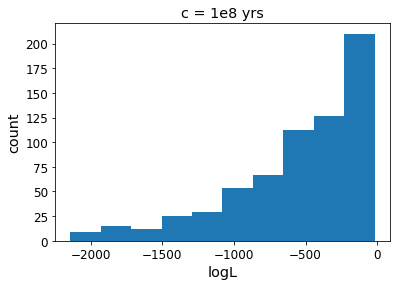

      m    b            c    f  \
10 -1.0  0.0  158489319.0  0.1   
11 -1.0  0.0  158489319.0  0.2   
12 -1.0  0.0  158489319.0  0.3   
13 -1.0  0.0  158489319.0  0.4   
14 -1.0  0.0  158489319.0  0.5   

                                                   tm        logL  
10                  [208.3, 10.8, 0.0, 0.0, 0.0, 0.0] -943.583115  
11                  [391.6, 24.8, 0.0, 0.0, 0.0, 0.0] -577.285372  
12                  [600.9, 34.5, 0.0, 0.0, 0.0, 0.0] -452.467960  
13  [852.4000000000001, 48.800000000000004, 0.0, 0... -426.517629  
14                 [1041.5, 62.5, 0.0, 0.0, 0.0, 0.0] -454.740932  


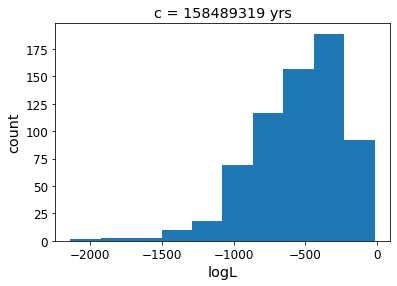

      m    b            c    f  \
20 -1.0  0.0  251188643.0  0.1   
21 -1.0  0.0  251188643.0  0.2   
22 -1.0  0.0  251188643.0  0.3   
23 -1.0  0.0  251188643.0  0.4   
24 -1.0  0.0  251188643.0  0.5   

                                                   tm        logL  
20  [204.10000000000002, 11.600000000000001, 0.0, ... -941.992335  
21     [394.40000000000003, 25.0, 0.0, 0.0, 0.0, 0.0] -575.884591  
22                  [575.4, 36.3, 0.0, 0.0, 0.0, 0.0] -451.257180  
23  [810.4000000000001, 46.400000000000006, 0.0, 0... -425.496848  
24                 [1044.5, 64.0, 0.0, 0.0, 0.0, 0.0] -453.910151  


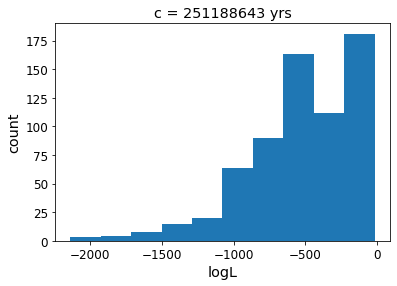

In [219]:
print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[0], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[0], 0))].logL)
plt.title('c = 1e8 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].logL)
plt.title('c = 158489319 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].logL)
plt.title('c = 251188643 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()


The former distribution does seem to have a shorter tail than the latter. Let's revisit this for other ground truths.

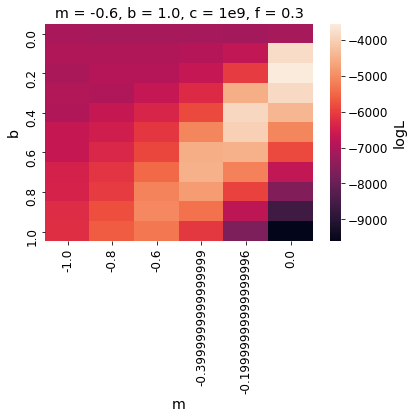

In [220]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -0.6, b = 1.0, c = 1e9, f = 0.3')
plt.show()

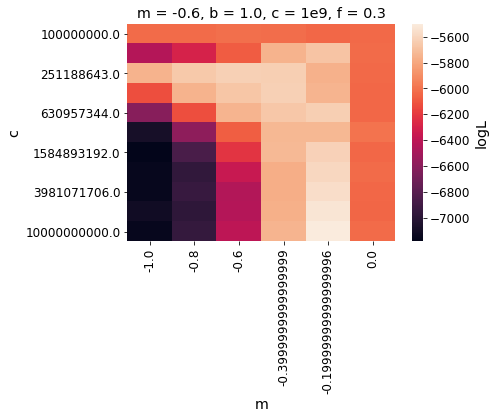

In [221]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.c.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -0.6, b = 1.0, c = 1e9, f = 0.3')
plt.show()

1D posteriors show that I can recover m and c, but not quite f and definitely not b. 2D posteriors corroborate this for m and b, and they suggest that there are fast sculpting models with even shorter cutoff times that are also favored. 

Identify best and good models

In [222]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == -0.6) & (model_logLs.b == 1.) & (np.round(model_logLs.c, -8) == 1e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth)
delta_logL = best_logL - ground_truth.logL.to_list()[0]

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) <= delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:          m    b             c    f  \
6592  0.0  0.4  1.000000e+10  0.3   

                                                     tm       logL  
6592  [653.1, 163.79999999999998, 71.7, 35.4, 7.5, 0... -17.482551  
Ground truth:          m    b             c    f                                    tm  \
3572 -0.6  1.0  1.000000e+09  0.3  [677.4, 171.0, 66.6, 25.8, 6.6, 0.6]   

           logL  
3572 -17.647927  
Some models between best model and ground truth: 
        m    b             c    f  \
442  -1.0  0.4  1.000000e+08  0.3   
3572 -0.6  1.0  1.000000e+09  0.3   
5552 -0.2  0.6  1.000000e+09  0.3   
6592  0.0  0.4  1.000000e+10  0.3   

                                                     tm       logL  
442   [655.1999999999999, 170.4, 66.89999999999999, ... -17.543887  
3572               [677.4, 171.0, 66.6, 25.8, 6.6, 0.6] -17.647927  
5552  [673.8, 164.7, 69.89999999999999, 30.599999999... -17.535186  
6592  [653.1, 163.79999999999998, 71.7, 35.4, 7.5, 0... -17.

Plot these models

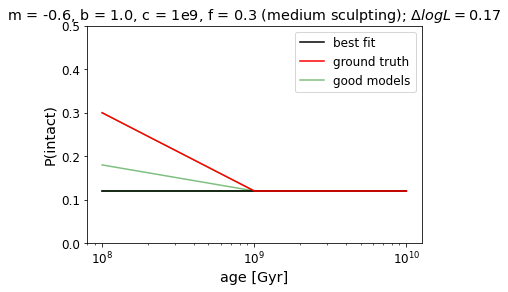

In [230]:
x = np.logspace(8, 10, 1000)

# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='good models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(f'm = -0.6, b = 1.0, c = 1e9, f = 0.3 (medium sculpting); $\Delta logL = {np.round(delta_logL, 2)}$')
plt.legend()
plt.show()

In [232]:
good_models

,m,b,c,f,tm,logL
442,-1.0,0.4,1.000000e+08,0.3,"[655.1999999999999, 170.4, 66.89999999999999, ...",-17.543887
3572,-0.6,1.0,1.000000e+09,0.3,"[677.4, 171.0, 66.6, 25.8, 6.6, 0.6]",-17.647927
5552,-0.2,0.6,1.000000e+09,0.3,"[673.8, 164.7, 69.89999999999999, 30.599999999...",-17.535186
6592,0.0,0.4,1.000000e+10,0.3,"[653.1, 163.79999999999998, 71.7, 35.4, 7.5, 0...",-17.482551


Huh. It's weird that there are so few good models and that they're so far apart. 

In [241]:
test_tm = model_logLs.loc[(model_logLs.m == 0.) & (np.round(model_logLs.b,1) == 0.3) & (np.round(model_logLs.c, -8) == 1e10) & (np.round(model_logLs.f,1) == 0.3)].tm
print(np.sum(test_tm))
print(np.sum(ground_truth.tm))
better_loglike(np.sum(test_tm), np.sum(ground_truth.tm))

[641.6999999999999, 127.5, 54.9, 23.099999999999998, 3.9, 0.0]
[677.4, 171.0, 66.6, 25.8, 6.6, 0.6]


-24.76028406895447

I guess as long as they end up with the same present-day intact fraction...

And above are the corresponding plots for medium sculpting (m = -0.6, b = 1.0, c = 1e9, f = 0.3). I show again the logL distributions of the first three cutoff thresholds, and I think they are consistent with what we see in the 1D marginalized likelihood subplot. This time, it’s the third cutoff time that’s favored, although that is still well younger than most of the stars in our sample. Finally, the bubble of good models continues to be tiny, with only two other models allowed between the ground truth and best fit. At least they all end in the same present-day intact fraction.

#### Model 4: m = 0, b = 0.5, c = 1e9, f = 0.3 (no sculpting)


In [242]:
tm_fiducial = truth.loc[(truth.ms == 0.) & (truth.bs == 0.5) & (np.round(truth.cs, -8) == 1e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

7262    [658.8, 183.0, 85.2, 38.1, 11.4, 2.1]
Name: transit_multiplicities, dtype: object

In [243]:
test_recovery = recovery.loc[(recovery.ms == 0.) & (recovery.bs == 0.5) & (np.round(recovery.cs, -8) == 1e9) & (np.round(recovery.fs,1) == 0.3)]
#test_recovery

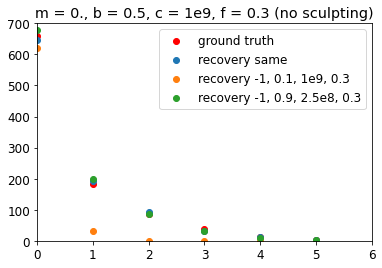

In [244]:
plt.scatter(np.arange(len(tm_fiducial[7262])), tm_fiducial[7262], color='r', label='ground truth')
plt.scatter(np.arange(len(recovery.iloc[217860].transit_multiplicities)), recovery.iloc[217860].transit_multiplicities, label='recovery same')
plt.scatter(np.arange(len(recovery.iloc[5470].transit_multiplicities)), recovery.iloc[5470].transit_multiplicities, label='recovery -1, 0.1, 1e9, 0.3')
plt.scatter(np.arange(len(recovery.iloc[33360].transit_multiplicities)), recovery.iloc[33360].transit_multiplicities, label='recovery -1, 0.9, 2.5e8, 0.3')

plt.xlim([0,6])
plt.ylim([0,700])
plt.title('m = 0., b = 0.5, c = 1e9, f = 0.3 (no sculpting)')
plt.legend()
plt.show()

In [245]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # keep median logL for each model
                    median_logL = np.median(logLs)
                    median_arg = argmedian(logLs)
                    all_logLs.append(median_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[median_arg])

                except:
                    all_logLs.append(0.)
                
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'tm': all_transit_multiplicities, 'logL': all_logLs})
        

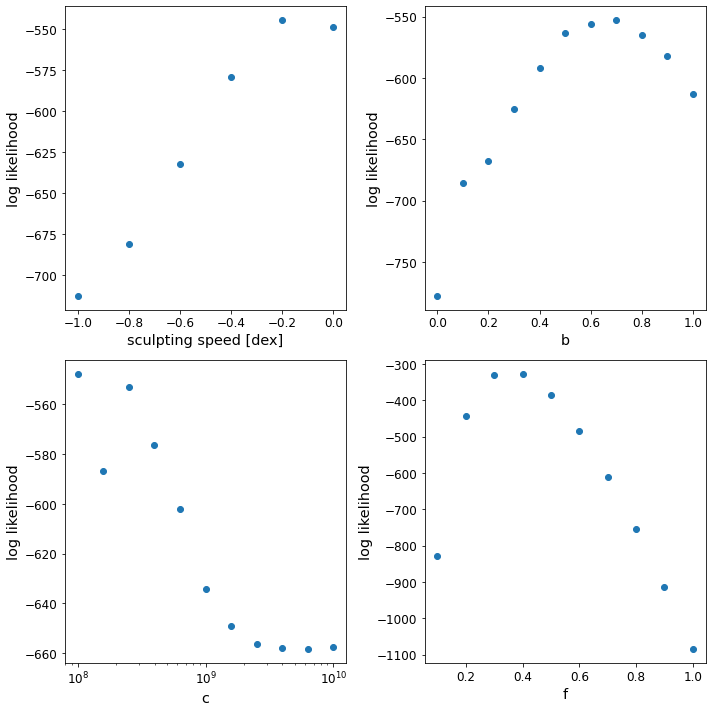

In [246]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.m == cube[0])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.b == cube[1])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(model_logLs.c == cube[2])]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

Second cutoff threshold mystery

     m    b            c    f                                  tm         logL
0 -1.0  0.0  100000000.0  0.1   [202.3, 12.0, 0.0, 0.0, 0.0, 0.0] -1075.874264
1 -1.0  0.0  100000000.0  0.2   [397.6, 24.8, 0.0, 0.0, 0.0, 0.0]  -706.331536
2 -1.0  0.0  100000000.0  0.3   [608.1, 36.6, 0.0, 0.0, 0.0, 0.0]  -578.034013
3 -1.0  0.0  100000000.0  0.4   [829.6, 49.6, 0.0, 0.0, 0.0, 0.0]  -551.590149
4 -1.0  0.0  100000000.0  0.5  [1015.0, 59.0, 0.0, 0.0, 0.0, 0.0]  -581.794304


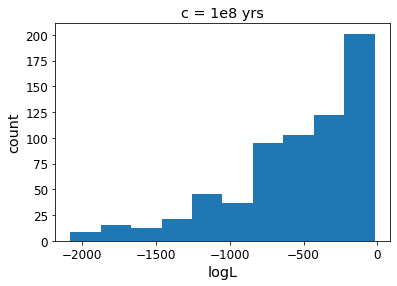

      m    b            c    f  \
10 -1.0  0.0  158489319.0  0.1   
11 -1.0  0.0  158489319.0  0.2   
12 -1.0  0.0  158489319.0  0.3   
13 -1.0  0.0  158489319.0  0.4   
14 -1.0  0.0  158489319.0  0.5   

                                                   tm         logL  
10    [205.9, 11.200000000000001, 0.0, 0.0, 0.0, 0.0] -1079.935210  
11    [395.8, 24.200000000000003, 0.0, 0.0, 0.0, 0.0]  -711.580290  
12                  [622.8, 33.9, 0.0, 0.0, 0.0, 0.0]  -587.682586  
13  [852.4000000000001, 48.800000000000004, 0.0, 0...  -559.431174  
14                 [1003.0, 55.5, 0.0, 0.0, 0.0, 0.0]  -586.835555  


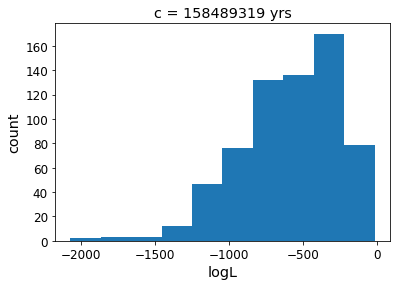

      m    b            c    f  \
20 -1.0  0.0  251188643.0  0.1   
21 -1.0  0.0  251188643.0  0.2   
22 -1.0  0.0  251188643.0  0.3   
23 -1.0  0.0  251188643.0  0.4   
24 -1.0  0.0  251188643.0  0.5   

                                                   tm         logL  
20                  [201.8, 12.0, 0.0, 0.0, 0.0, 0.0] -1077.323469  
21                  [414.6, 22.8, 0.0, 0.0, 0.0, 0.0]  -709.317972  
22                  [575.4, 36.3, 0.0, 0.0, 0.0, 0.0]  -583.143711  
23  [810.4000000000001, 46.400000000000006, 0.0, 0...  -557.189602  
24                 [1013.0, 58.0, 0.0, 0.0, 0.0, 0.0]  -584.129225  


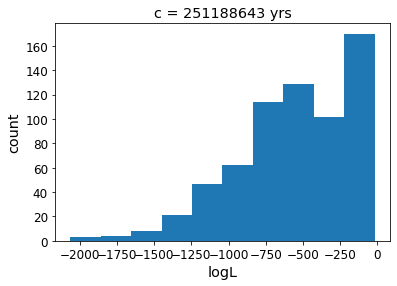

In [247]:
print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[0], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[0], 0))].logL)
plt.title('c = 1e8 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[1], 0))].logL)
plt.title('c = 158489319 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

print(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].head())
plt.hist(model_logLs.loc[(model_logLs.c == np.round(np.sort(truth.cs.unique())[2], 0))].logL)
plt.title('c = 251188643 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()


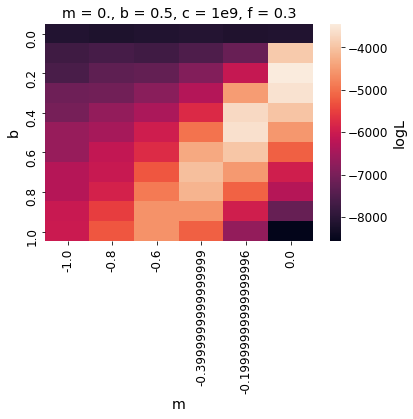

In [154]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = 0., b = 0.5, c = 1e9, f = 0.3')
plt.show()

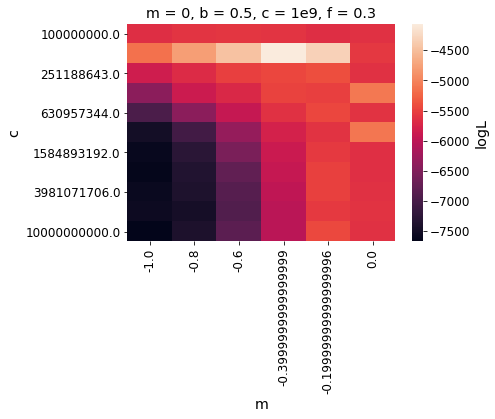

In [155]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.c.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = 0, b = 0.5, c = 1e9, f = 0.3')
plt.show()

We totally miss the mark on recovering the lack of sculpting in the fake ground truth. We do recover b and f, and of course c is not a sensible variable in the case of no sculpting. 

Identify best and good models

In [251]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(model_logLs.m == 0.) & (model_logLs.b == 0.5) & (np.round(model_logLs.c, -8) == 1e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth)
delta_logL = best_logL - ground_truth.logL.to_list()[0]

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) < delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:          m    b            c    f  \
6642  0.0  0.5  630957344.0  0.3   

                                                     tm       logL  
6642  [664.5, 195.0, 81.89999999999999, 31.799999999... -18.430506  
Ground truth:          m    b             c    f  \
6652  0.0  0.5  1.000000e+09  0.3   

                                                     tm       logL  
6652  [673.8, 201.0, 84.0, 32.1, 11.7, 1.79999999999... -18.652577  
Some models between best model and ground truth: 
        m    b             c    f  \
5812 -0.2  0.8  6.309573e+09  0.3   
5822 -0.2  0.8  1.000000e+10  0.3   
6622  0.0  0.5  2.511886e+08  0.3   
6642  0.0  0.5  6.309573e+08  0.3   

                                                     tm       logL  
5812  [679.1999999999999, 195.6, 95.39999999999999, ... -18.548619  
5822  [668.1, 187.79999999999998, 83.7, 36.9, 9.9, 0.6] -18.546571  
6622  [678.0, 203.7, 87.89999999999999, 39.3, 11.7, ... -18.534963  
6642  [664.5, 195.0, 81.899999999999

In [249]:
good_models

,m,b,c,f,tm,logL
5812,-0.2,0.8,6.309573e+09,0.3,"[679.1999999999999, 195.6, 95.39999999999999, ...",-18.548619
5822,-0.2,0.8,1.000000e+10,0.3,"[668.1, 187.79999999999998, 83.7, 36.9, 9.9, 0.6]",-18.546571
6622,0.0,0.5,2.511886e+08,0.3,"[678.0, 203.7, 87.89999999999999, 39.3, 11.7, ...",-18.534963
6642,0.0,0.5,6.309573e+08,0.3,"[664.5, 195.0, 81.89999999999999, 31.799999999...",-18.430506


Plot these models

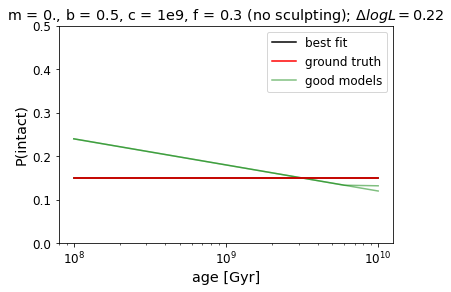

In [250]:
x = np.logspace(8, 10, 10)

# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='good models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(f'm = 0., b = 0.5, c = 1e9, f = 0.3 (no sculpting); $\Delta logL = {np.round(delta_logL,2)}$')
plt.legend()
plt.show()

Finally, for the no-sculpting model (m = 0, b = 0.5, c = 1e9, f = 0.3), I get the following plots. The question of why delta logL is so small remains, but again, at least all good models result in roughly the same present-day intact fraction.

Perhaps I need to try a very slow (m=-0.2) and long-lived (c=4e9 yrs or something like that).


#### Model 5: slow sculpting (m=-0.2, b=1.0, c=4e9 yrs, f=0.3)

In [256]:
tm_fiducial = truth.loc[(np.round(truth.ms,1) == -0.2) & (truth.bs == 1.) & (np.round(truth.cs, -8) == 4e9) & (np.round(truth.fs,1) == 0.3)].transit_multiplicities
tm_fiducial

6572    [676.5, 250.2, 131.4, 50.699999999999996, 15.0...
Name: transit_multiplicities, dtype: object

In [303]:
test_recovery = recovery.loc[(recovery.ms == -0.2) & (recovery.bs == 1.) & (np.round(recovery.cs, -8) == 4e9) & (np.round(recovery.fs,1) == 0.3)]
test_recovery

,ms,bs,cs,fs,transit_multiplicities,geom_transit_multiplicities,intact_fracs,disrupted_fracs,logLs
197160,-0.2,1.0,3.981072e+09,0.3,"[690.0, 270.0, 112.5, 41.4, 12.0, 2.4]","[918.0, 412.8, 283.5, 184.5, 98.39999999999999...",0.269299,0.030701,-119.869942
197161,-0.2,1.0,3.981072e+09,0.3,"[693.9, 264.9, 109.5, 54.6, 16.8, 3.0]","[955.5, 398.09999999999997, 294.0, 200.1, 94.2...",0.269213,0.030787,-127.323692
197162,-0.2,1.0,3.981072e+09,0.3,"[686.4, 243.6, 122.39999999999999, 50.69999999...","[934.1999999999999, 404.7, 282.0, 198.29999999...",0.269689,0.030311,-122.047157
197163,-0.2,1.0,3.981072e+09,0.3,"[670.5, 250.79999999999998, 126.3, 51.9, 13.5,...","[919.8, 399.59999999999997, 277.8, 198.6, 100....",0.269282,0.030718,-131.158620
197164,-0.2,1.0,3.981072e+09,0.3,"[673.5, 240.89999999999998, 131.7, 42.6, 13.5,...","[940.1999999999999, 385.5, 278.09999999999997,...",0.269463,0.030537,-124.907605
197165,-0.2,1.0,3.981072e+09,0.3,"[665.1, 262.8, 119.39999999999999, 53.4, 16.2,...","[939.0, 414.9, 279.59999999999997, 195.2999999...",0.269086,0.030914,-136.327569
197166,-0.2,1.0,3.981072e+09,0.3,"[698.4, 273.0, 138.0, 48.3, 17.4, 1.5]","[938.4, 426.3, 293.09999999999997, 207.0, 101....",0.269690,0.030310,-144.676130
197167,-0.2,1.0,3.981072e+09,0.3,"[692.4, 260.7, 124.19999999999999, 47.1, 13.79...","[949.8, 412.8, 279.9, 193.79999999999998, 96.6...",0.269095,0.030905,-126.081088
197168,-0.2,1.0,3.981072e+09,0.3,"[706.8, 263.09999999999997, 120.3, 52.19999999...","[959.4, 394.8, 290.4, 198.0, 97.8, 22.8]",0.269283,0.030717,-127.360049
197169,-0.2,1.0,3.981072e+09,0.3,"[680.6999999999999, 264.9, 114.0, 55.8, 15.299...","[935.4, 403.5, 280.8, 190.5, 91.5, 17.7]",0.269413,0.030587,-130.833560


In [304]:
better_loglike(np.array([690.0, 270.0, 112.5, 41.4, 12.0, 2.4]), np.sum(tm_fiducial))

-21.473996014391417

In [279]:
cube = [0,0,0]
fs = np.round(np.linspace(0.1, 1., 10), 1)
ndim = 3
nparams = 3

ms = []
bs = []
cs = []
fs_for_df = []
all_logLs = []
all_transit_multiplicities = []

for gi_m in range(6):
    
    for gi_b in range(11):

        for gi_c in range(11):
            cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
            
            for f in fs:
                
                ms.append(cube[0])
                bs.append(cube[1])
                cs.append(cube[2])
                fs_for_df.append(f)
                
                try:
                    #tm = truth.loc[(truth.ms == cube[0]) & (truth.bs == cube[1]) & (np.round(truth.cs, 0) == cube[2]) & (np.round(truth.fs,1) == f)].transit_multiplicities
                    tm_recovery = recovery.loc[(np.round(recovery.ms,1) == np.round(cube[0],1)) & (np.round(recovery.bs,1) == np.round(cube[1],1)) & (np.round(recovery.cs, 0) == np.round(cube[2],0)) & (np.round(recovery.fs,1) == f)].transit_multiplicities.to_list()
                    
                    # calculate logL for each realization of each model, using tm as the ground truth
                    logLs = []
                    for i in range(len(tm_recovery)):
                        logL = better_loglike(tm_recovery[i], np.sum(tm_fiducial))
                        logLs.append(logL)

                    # keep median logL for each model
                    median_logL = np.median(logLs)
                    median_arg = argmedian(logLs)
                    all_logLs.append(median_logL)
                    # append transit multiplicity of the best sample for that model
                    all_transit_multiplicities.append(tm_recovery[median_arg])

                except:
                    all_logLs.append(0.)
                
model_logLs = pd.DataFrame({'m': ms, 'b': bs, 'c': cs, 'f': fs_for_df, 
                            'tm': all_transit_multiplicities, 'logL': all_logLs})
        

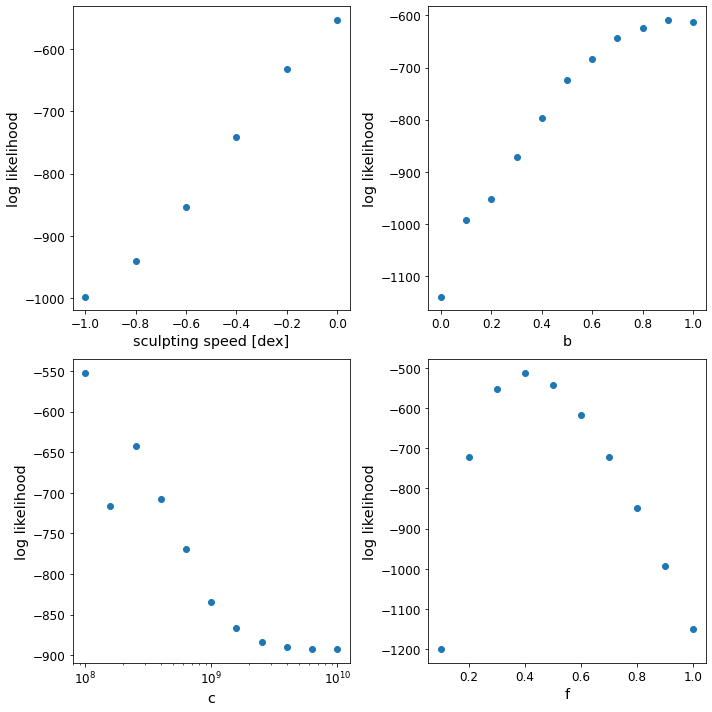

In [294]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

# marginalize in 1D
marginalized_logLs = []
for gi_m in range(6):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.m, 1) == np.round(cube[0], 1))]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))

ax1.scatter(truth.ms.unique(), marginalized_logLs)
ax1.set_ylabel("log likelihood")
ax1.set_xlabel("sculpting speed [dex]")

marginalized_logLs = []
for gi_b in range(11):
    
    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.b,1) == np.round(cube[1], 1))]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax2.scatter(model_logLs.b.unique(), marginalized_logLs)
ax2.set_ylabel("log likelihood")
ax2.set_xlabel("b")

marginalized_logLs = []
for gi_c in range(11):

    cube = prior_grid_logslope(cube, ndim, nparams, gi_m, gi_b, gi_c)
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.c,0) == np.round(cube[2], 0))]# & (model_logLs.f == 0.3)]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax3.scatter(truth.cs.unique(), marginalized_logLs)
ax3.set_ylabel("log likelihood")
ax3.set_xlabel("c")
ax3.set_xscale('log')

marginalized_logLs = []
for gi_f in np.linspace(0.1, 1, 10):
    
    # subset
    only = model_logLs.loc[(np.round(model_logLs.f, 1) == np.round(gi_f, 1))]
    
    # marginalize logL
    marginalized_logLs.append(np.mean(only.logL))
ax4.scatter(np.linspace(0.1, 1, 10), marginalized_logLs)
ax4.set_ylabel("log likelihood")
ax4.set_xlabel("f")

plt.tight_layout()
plt.show()

It appears our framework is indeed insensitive to long sculpting timescales, favoring shorter cutoff thresholds even when the ground truth is ~1 Gyr. Let's do the logL histograms as with the other ground truths to further examine this.

In [302]:
model_logLs

6572    [676.5, 250.2, 131.4, 50.699999999999996, 15.0...
Name: transit_multiplicities, dtype: object

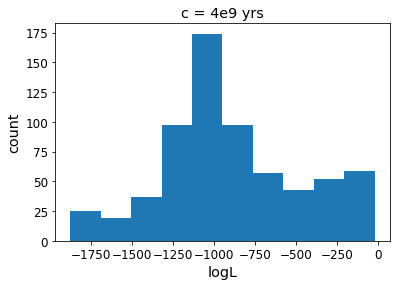

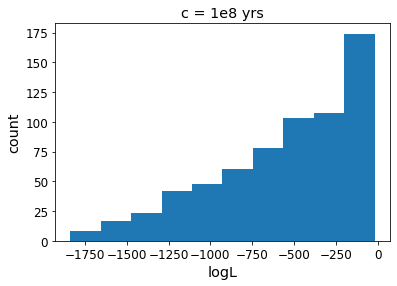

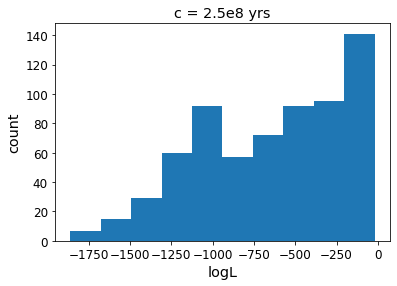

In [306]:
want = model_logLs.loc[(np.round(model_logLs.c, -8) == 4e9)]

plt.hist(want.logL)
plt.title('c = 4e9 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

first_threshold = model_logLs.loc[(np.round(model_logLs.c, -7) == 1e8)]
plt.hist(first_threshold.logL)
plt.title('c = 1e8 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

third_threshold = model_logLs.loc[(np.round(model_logLs.c, -7) == 2.5e8)]
plt.hist(third_threshold.logL)
plt.title('c = 2.5e8 yrs')
plt.xlabel('logL')
plt.ylabel('count')
plt.show()

Indeed, the long ground truth sculpting timescale peaks at -1000 logL, versus the shorter timescales that peak close to 0. Perhaps the log spacing convolved with the age distribution of the stellar sample means that longer timescales are always playing a losing game, in which marginalizing over 1D penalizes slow sculpting and/or high initial intact fractions by lumping them in with moderate and faster sculpting, which exert oversized influence over very long (Gyr+) timescales. So, let's examine the 2D marginalized likelihoods.

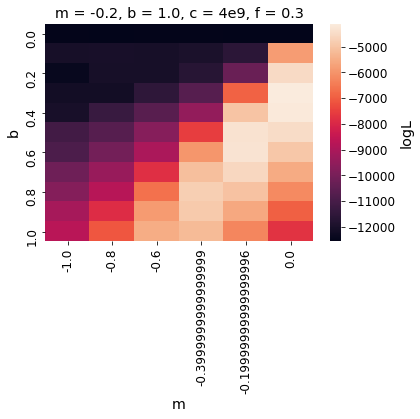

In [307]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','b']).sum('logL').reset_index()

piv = piv.pivot("b","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.b.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -0.2, b = 1.0, c = 4e9, f = 0.3')
plt.show()

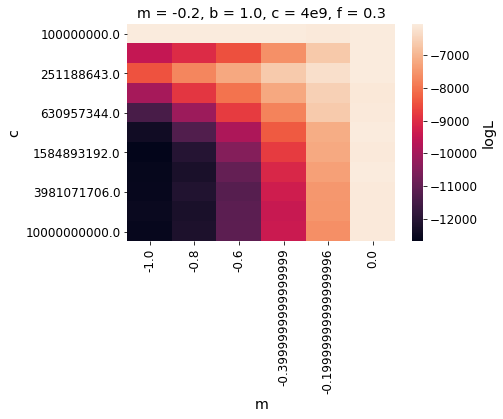

In [308]:
piv = model_logLs.groupby(['m','b','c']).mean('logL').reset_index().groupby(['m','c']).sum('logL').reset_index()

piv = piv.pivot("c","m","logL") # vs logged_normalized_likelihood
#print(np.nanmin(piv.values), np.nanmax(piv.values), np.nansum(piv.values), np.nansum(np.log(piv.values)), np.log(np.nansum(piv.values)))
#print(np.log(np.nanmin(piv.values)), np.log(np.nanmax(piv.values)))

fig, ax = plt.subplots()
sns.heatmap(piv, yticklabels=model_logLs.c.unique().round(1), cbar_kws={'label': 'logL'})
#sns.heatmap(piv, vmin=-455, vmax=-17.9)
ax.set_yticks(ax.get_yticks()[::2]) # sample every other tick, for cleanness
plt.title('m = -0.2, b = 1.0, c = 4e9, f = 0.3')
plt.show()

Even within the m=-0.2 column, the best cutoff timescales are sub-Gyr, with the ground truth of 4 Gyrs being relatively disfavored. Similarly, the ground truth initial intact fraction of 1.0 is only moderately favored compared to 0.5, even within the m=-0.2 column. 

Finally, let's plot good, best, and ground truth models.

In [290]:
best_logL = max(model_logLs.loc[model_logLs.logL < 0.].logL)
print("Best model: ", model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)])

ground_truth = model_logLs.loc[(np.round(model_logLs.m, 1) == -0.2) & (model_logLs.b == 1.) & (np.round(model_logLs.c, -8) == 4e9) & (np.round(model_logLs.f,1) == 0.3)]
print("Ground truth: ", ground_truth)
delta_logL = best_logL - ground_truth.logL.to_list()[0]

good_models = model_logLs.loc[np.abs(model_logLs.logL - best_logL) < delta_logL]
print("Some models between best model and ground truth: ")
print(good_models.head())

Best model:          m    b            c    f  \
6842  0.0  0.7  251188643.0  0.3   

                                                     tm       logL  
6842  [672.3, 255.89999999999998, 122.1, 45.0, 14.39... -19.037579  
Ground truth:          m    b             c    f  \
6022 -0.2  1.0  3.981072e+09  0.3   

                                                     tm       logL  
6022  [682.1999999999999, 253.2, 126.3, 59.4, 16.5, ... -19.125226  
Some models between best model and ground truth: 
        m    b            c    f  \
6842  0.0  0.7  251188643.0  0.3   

                                                     tm       logL  
6842  [672.3, 255.89999999999998, 122.1, 45.0, 14.39... -19.037579  


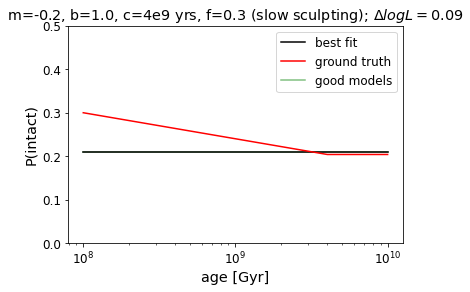

In [311]:
x = np.logspace(8, 10, 1000)

# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

# models as good as or better than ground truth
good_models = good_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in good_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='good models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(f'm=-0.2, b=1.0, c=4e9 yrs, f=0.3 (slow sculpting); $\Delta logL = {np.round(delta_logL,2)}$')
plt.legend()
plt.show()

In [292]:
good_models

,m,b,c,f,tm,logL
6842,0.0,0.7,251188643.0,0.3,"[672.3, 255.89999999999998, 122.1, 45.0, 14.39...",-19.037579


Lol. Okay, how about we extend the bubble of what constitutes a "good model". 

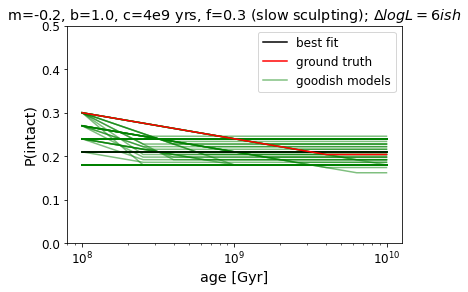

In [316]:
x = np.logspace(8, 10, 1000)

# best model
best_model = model_logLs.loc[(model_logLs.logL >= best_logL) & (model_logLs.logL < 0.)]
m, b, c, f = best_model.m.to_list()[0], best_model.b.to_list()[0], best_model.c.to_list()[0], best_model.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='best fit', color='k')

# ground truth
m, b, c, f = ground_truth.m.to_list()[0], ground_truth.b.to_list()[0], ground_truth.c.to_list()[0], ground_truth.f.to_list()[0]
plt.plot(x, build_models(x, m, b, c, f), label='ground truth', color='r')

# models as good as or better than ground truth
goodish_models = model_logLs.loc[model_logLs.logL > -25]
goodish_models = goodish_models.drop_duplicates(subset=['m','b','c','f'])
label_flag = True
for index, row in goodish_models.reset_index().iterrows(): 
    m, b, c, f = row.m, row.b, row.c, row.f
    if label_flag == True:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, label='goodish models', alpha=0.5)
    elif label_flag == False:
        plt.plot(x, build_models(x, m, b, c, f), color='green', zorder=0, alpha=0.5)
    label_flag = False  
    
plt.xscale('log')
plt.ylim([0, 0.5])
plt.xlabel('age [Gyr]')
plt.ylabel('P(intact)')
plt.title(r'm=-0.2, b=1.0, c=4e9 yrs, f=0.3 (slow sculpting); $\Delta logL = 6ish$')
plt.legend()
plt.show()